# Hazem Zaky
# Programming Exercise \#4
---

# Preamble

In [105]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive
'''
# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
### %cd /content/drive/My\ Drive/[MY PATH] ###
'''

"\n# mount Google Drive in Google Colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# change directory using the magic command %cd\n### replace [MY PATH] below with your own path in Google Drive ###\n### %cd /content/drive/My\\ Drive/[MY PATH] ###\n"

In [106]:
# import relevant Python libraries

import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Machine Learning for Diagnosis of 'Senioritis'**

## Problem 1.1

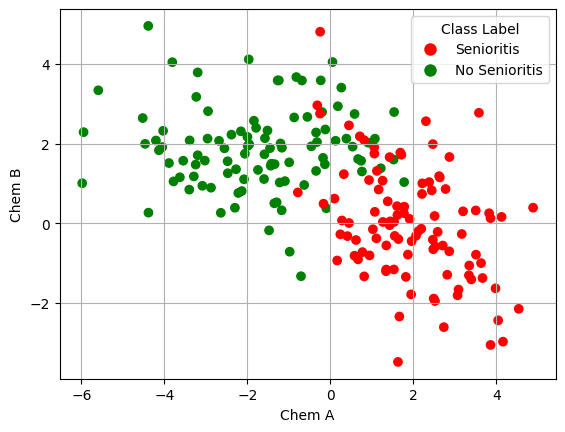

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
senioritis_train = pd.read_csv('data/SenioritisTrainingData.csv', engine="python") 

# Filter data by class label
no_senioritis_train = senioritis_train[senioritis_train['ClassLabel'] == "No Senioritis"]
has_senioritis_train = senioritis_train[senioritis_train['ClassLabel'] == "Senioritis"]

# Define colors for each class
colors = {"Senioritis": "red", "No Senioritis": "green"}

# Create the scatter plot
plt.scatter(senioritis_train["ChemA"], senioritis_train["ChemB"], 
            c=senioritis_train["ClassLabel"].map(colors), label=senioritis_train["ClassLabel"])

# Add labels and grid
plt.xlabel("Chem A")
plt.ylabel("Chem B")
plt.grid(True)

# Add legend
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                 for label, color in colors.items()]
plt.legend(handles=legend_labels, title="Class Label")

# Show the plot
plt.show()


## Problem 1.2

### (a)

In [108]:
import numpy as np

class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
        self.means = None  # To store class means for prediction
        self.priors = None  # To store class priors for prediction
        self.classes = None  # To store unique class labels

    def fit(self, X, y):
        n_features = X.shape[1]
        self.classes = np.unique(y)

        # Step 1: Compute the mean of each class and the overall mean
        mean_overall = np.mean(X, axis=0)
        self.means = {label: np.mean(X[y == label], axis=0) for label in self.classes}
        self.priors = {label: (y == label).mean() for label in self.classes}

        # Step 2: Compute the within-class and between-class scatter matrices
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))

        for c in self.classes:
            X_c = X[y == c]
            mean_c = self.means[c]
            # Within-class scatter matrix
            S_W += (X_c - mean_c).T @ (X_c - mean_c)

            # Between-class scatter matrix
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            S_B += n_c * (mean_diff @ mean_diff.T)

        # Step 3: Solve the generalized eigenvalue problem for S_W^(-1) * S_B
        eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)

        # Step 4: Sort eigenvectors by eigenvalues in descending order
        eigvecs = eigvecs[:, np.argsort(-eigvals.real)]
        self.linear_discriminants = eigvecs[:, :self.n_components]

    def transform(self, X):
        # Step 5: Project the data onto the linear discriminants
        return np.dot(X, self.linear_discriminants)

    def predict(self, X):
        predictions = []
        for x in X:
            discriminants = {}
            for c in self.classes:
                # Project the data point onto the linear discriminant
                projected_x = np.dot(self.linear_discriminants.T, x)
                mean_c_projected = np.dot(self.linear_discriminants.T, self.means[c])

                # Calculate the discriminant function for each class
                discriminants[c] = np.dot(projected_x, mean_c_projected) - 0.5 * np.dot(mean_c_projected, mean_c_projected) + np.log(self.priors[c])

            # Predict the class with the highest discriminant value
            predictions.append(max(discriminants, key=discriminants.get))

        return np.array(predictions)


### (b)

In [109]:
class QDA:
    def __init__(self):
        self.means = None
        self.priors = None
        self.cov_matrices = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {cls: X[y == cls].mean(axis=0) for cls in self.classes}
        self.priors = {cls: (y == cls).mean() for cls in self.classes}
        self.cov_matrices = {cls: np.cov(X[y == cls].T) for cls in self.classes}

    def predict(self, X):
        predictions = []
        for x in X:
            discriminants = {cls: -0.5 * np.log(np.linalg.det(self.cov_matrices[cls])) -
                             0.5 * (x - self.means[cls]).T @ np.linalg.inv(self.cov_matrices[cls]) @ (x - self.means[cls]) +
                             np.log(self.priors[cls]) for cls in self.classes}
            predictions.append(max(discriminants, key=discriminants.get))
        return np.array(predictions)



### (c)

In [110]:
class GaussianNB:
    def __init__(self):
        self.means = None
        self.vars = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {cls: X[y == cls].mean(axis=0) for cls in self.classes}
        self.vars = {cls: X[y == cls].var(axis=0) for cls in self.classes}
        self.priors = {cls: (y == cls).mean() for cls in self.classes}

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {cls: np.sum(-0.5 * np.log(2 * np.pi * self.vars[cls]) -
                                      ((x - self.means[cls]) ** 2) / (2 * self.vars[cls])) +
                             np.log(self.priors[cls]) for cls in self.classes}
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)


### (d)

In [111]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            # Compute distances from x to all training samples
            distances = np.linalg.norm(self.X_train - x, axis=1)
            # Find the k nearest neighbors
            k_indices = distances.argsort()[:self.k]
            k_neighbors = self.y_train[k_indices]
            # Predict the most common class among the neighbors
            predictions.append(np.bincount(k_neighbors).argmax())
        return np.array(predictions)



## Problem 1.3

### (a)

In [112]:
def evaluate_model_manual(model, X_test, y_test, description="Model"):
    # Predict the labels for the test data
    y_pred = model.predict(X_test)
    
    # Initialize confusion matrix components
    tp = 0  # True Positives
    tn = 0  # True Negatives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    # Compute confusion matrix components manually
    for true_label, predicted_label in zip(y_test, y_pred):
        if true_label == 1 and predicted_label == 1:
            tp += 1
        elif true_label == 0 and predicted_label == 0:
            tn += 1
        elif true_label == 0 and predicted_label == 1:
            fp += 1
        elif true_label == 1 and predicted_label == 0:
            fn += 1

    # Compute Metrics
    total_samples = len(y_test)
    error_rate = (fp + fn) / total_samples
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    fnr = fn / (tp + fn) if (tp + fn) > 0 else 0  # False Negative Rate

    # Return results as a dictionary
    return {
        "description": description,
        "error_rate": error_rate,
        "tp": tp,
        "tpr": tpr,
        "fp": fp,
        "fpr": fpr,
        "tn": tn,
        "tnr": tnr,
        "fn": fn,
        "fnr": fnr
    }

# Evaluate models and print results
def print_empirical_results(results, metric="Empirical"):
    print(f"--- {results['description']} Evaluation ---")
    
    if metric == "Empirical":
        print(f"Empirical Probability of Error: {results['error_rate']:.4f}")
    elif metric == "True Positive":
        print(f"True Positives (TP): {results['tp']}")
        print(f"True Positive Rate (TPR): {results['tpr']:.4f}")
    elif metric == "True Negative":
        print(f"True Negatives (TN): {results['tn']}")
        print(f"True Negative Rate (TNR): {results['tnr']:.4f}")
    elif metric == "False Positive":
        print(f"False Positives (FP): {results['fp']}")
        print(f"False Positive Rate (FPR): {results['fpr']:.4f}")
    elif metric == "False Negative":
        print(f"False Negatives (FN): {results['fn']}")
        print(f"False Negative Rate (FNR): {results['fnr']:.4f}")
    print()


test_data = pd.read_csv('data/SenioritisTestData.csv', engine='python')
X_test = test_data[['ChemA', 'ChemB']].values  # Feature matrix
y_test = test_data['ClassLabel'].map({'No Senioritis': 0, 'Senioritis': 1}).values  # Map labels to numerical values

train_data = pd.read_csv('data/SenioritisTrainingData.csv', engine='python')
X_train = train_data[['ChemA', 'ChemB']].values  # Feature matrix
y_train = train_data['ClassLabel'].map({'No Senioritis': 0, 'Senioritis': 1}).values  # Map labels to numerical values

# Evaluate LDA
lda = LDA(n_components=1)
lda.fit(X_train, y_train)
lda_results = evaluate_model_manual(lda, X_test, y_test, description="LDA")
print_empirical_results(lda_results, "Empirical")

# Evaluate QDA
qda = QDA()
qda.fit(X_train, y_train)
qda_results = evaluate_model_manual(qda, X_test, y_test, description="QDA")
print_empirical_results(qda_results, "Empirical")

# Evaluate Gaussian Naïve Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_results = evaluate_model_manual(gnb, X_test, y_test, description="Gaussian Naive Bayes")
print_empirical_results(gnb_results, "Empirical")

# Evaluate k-Nearest Neighbors
knn = KNN(k=3)
knn.fit(X_train, y_train)
knn_results = evaluate_model_manual(knn, X_test, y_test, description="k-Nearest Neighbors (k=3)")
print_empirical_results(knn_results, "Empirical")


--- LDA Evaluation ---
Empirical Probability of Error: 0.0850

--- QDA Evaluation ---
Empirical Probability of Error: 0.0900

--- Gaussian Naive Bayes Evaluation ---
Empirical Probability of Error: 0.0850

--- k-Nearest Neighbors (k=3) Evaluation ---
Empirical Probability of Error: 0.0950



### (b)

In [113]:
print_empirical_results(lda_results, "True Positive")
print_empirical_results(qda_results, "True Positive")
print_empirical_results(gnb_results, "True Positive")
print_empirical_results(knn_results, "True Positive")


--- LDA Evaluation ---
True Positives (TP): 89
True Positive Rate (TPR): 0.8900

--- QDA Evaluation ---
True Positives (TP): 88
True Positive Rate (TPR): 0.8800

--- Gaussian Naive Bayes Evaluation ---
True Positives (TP): 86
True Positive Rate (TPR): 0.8600

--- k-Nearest Neighbors (k=3) Evaluation ---
True Positives (TP): 91
True Positive Rate (TPR): 0.9100



### (c)

In [114]:
print_empirical_results(lda_results, "True Negative")
print_empirical_results(qda_results, "True Negative")
print_empirical_results(gnb_results, "True Negative")
print_empirical_results(knn_results, "True Negative")

--- LDA Evaluation ---
True Negatives (TN): 94
True Negative Rate (TNR): 0.9400

--- QDA Evaluation ---
True Negatives (TN): 94
True Negative Rate (TNR): 0.9400

--- Gaussian Naive Bayes Evaluation ---
True Negatives (TN): 97
True Negative Rate (TNR): 0.9700

--- k-Nearest Neighbors (k=3) Evaluation ---
True Negatives (TN): 90
True Negative Rate (TNR): 0.9000



### (d)

In [115]:
print_empirical_results(lda_results, "False Positive")
print_empirical_results(qda_results, "False Positive")
print_empirical_results(gnb_results, "False Positive")
print_empirical_results(knn_results, "False Positive")


--- LDA Evaluation ---
False Positives (FP): 6
False Positive Rate (FPR): 0.0600

--- QDA Evaluation ---
False Positives (FP): 6
False Positive Rate (FPR): 0.0600

--- Gaussian Naive Bayes Evaluation ---
False Positives (FP): 3
False Positive Rate (FPR): 0.0300

--- k-Nearest Neighbors (k=3) Evaluation ---
False Positives (FP): 10
False Positive Rate (FPR): 0.1000



### (e)

In [116]:
print_empirical_results(lda_results, "False Negative")
print_empirical_results(qda_results, "False Negative")
print_empirical_results(gnb_results, "False Negative")
print_empirical_results(knn_results, "False Negative")


--- LDA Evaluation ---
False Negatives (FN): 11
False Negative Rate (FNR): 0.1100

--- QDA Evaluation ---
False Negatives (FN): 12
False Negative Rate (FNR): 0.1200

--- Gaussian Naive Bayes Evaluation ---
False Negatives (FN): 14
False Negative Rate (FNR): 0.1400

--- k-Nearest Neighbors (k=3) Evaluation ---
False Negatives (FN): 9
False Negative Rate (FNR): 0.0900



## Problem 1.4

According to the data collected above, both the Gaussian Naive Bayes and LDA evaluations have the lowest empirical probability of error, making them the best classifiers under the 0-1 loss. Between these 2, the LDA classifier had a higher false positive rate, whereas the Gaussian Naive Bayes had a higher false negative rate. Because of this, I think the best model for the given scenario would be the LDA model. This it's less likely for the disease to go undetected, with the same empirical probability of error.

## Problem 1.5

### (a)

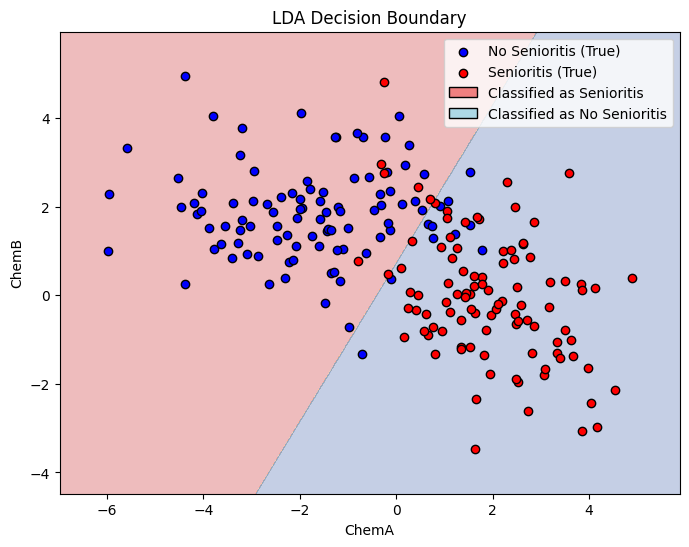

In [117]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Function to plot decision boundary with full legend
def plot_decision_boundary_with_full_legend(clf, X, y, title, resolution=0.01):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    # Predict class for each point in the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    background = ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    
    # Scatter plot for actual data points
    class_0 = y == 0  # "No Senioritis"
    class_1 = y == 1  # "Senioritis"
    ax.scatter(X[class_0, 0], X[class_0, 1], color="blue", label="No Senioritis (True)", edgecolor='k')
    ax.scatter(X[class_1, 0], X[class_1, 1], color="red", label="Senioritis (True)", edgecolor='k')
    
    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel("ChemA")
    ax.set_ylabel("ChemB")

    # Create custom legend handles for background classification
    legend_elements = [
        Patch(facecolor='lightcoral', edgecolor='k', label='Classified as Senioritis'),
        Patch(facecolor='lightblue', edgecolor='k', label='Classified as No Senioritis')
    ]
    # Combine legends
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles + legend_elements, loc="upper right")

    # Display the plot
    plt.show()

# Plotting LDA decision boundary
plot_decision_boundary_with_full_legend(lda, X_train, y_train, "LDA Decision Boundary")


### (b)

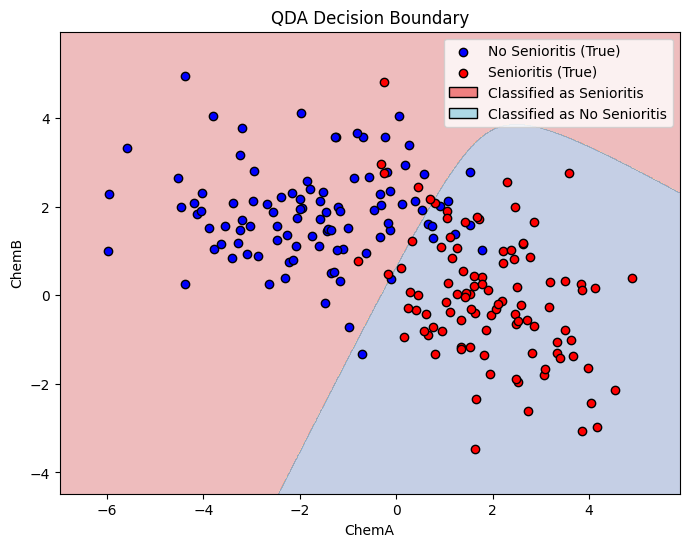

In [118]:
plot_decision_boundary_with_full_legend(qda, X_train, y_train, "QDA Decision Boundary")


### (c)

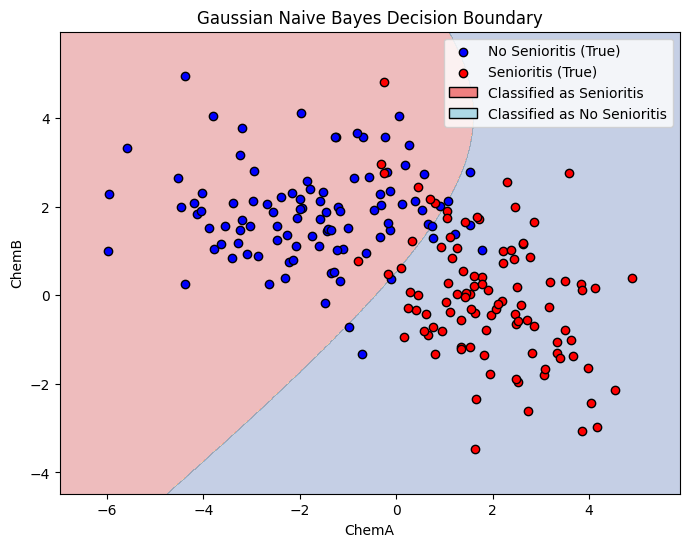

In [119]:
plot_decision_boundary_with_full_legend(gnb, X_train, y_train, "Gaussian Naive Bayes Decision Boundary")


### (d)

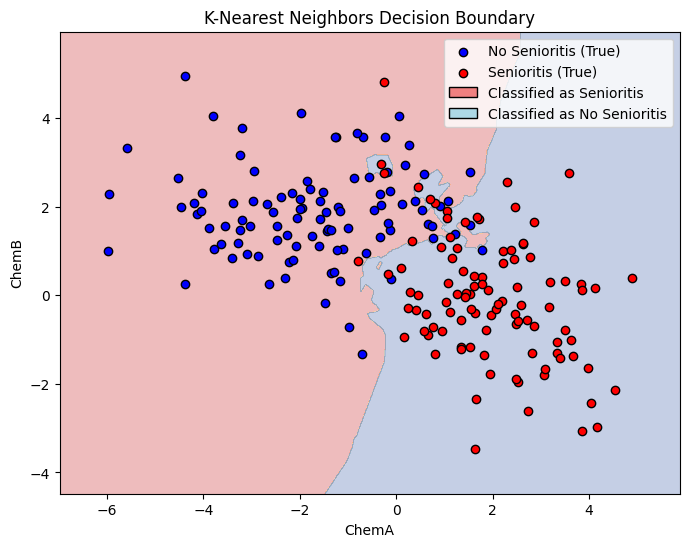

In [120]:
plot_decision_boundary_with_full_legend(knn, X_train, y_train, "K-Nearest Neighbors Decision Boundary")


### (e)

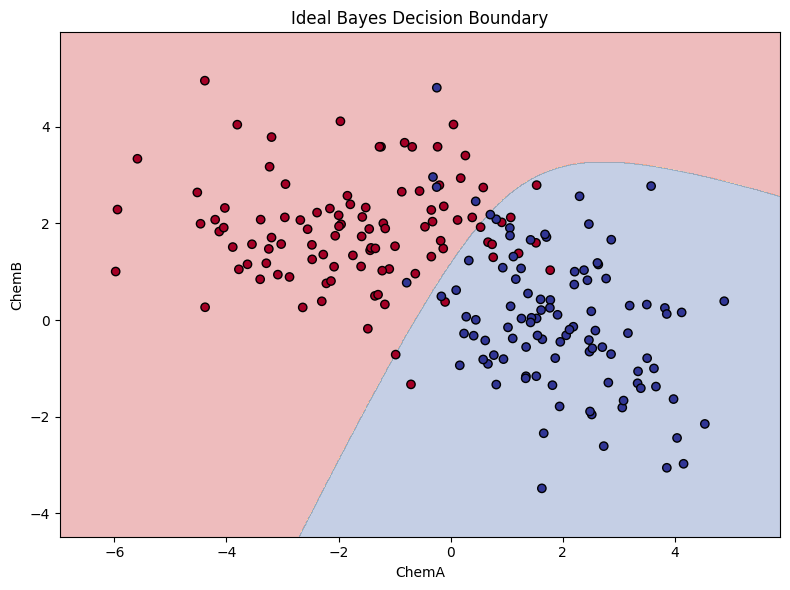

In [121]:
# Define parameters for the Gaussian distributions
mu_0 = np.array([-2, 2])  # Mean for class 0 (No Senioritis)
mu_1 = np.array([2, 0])   # Mean for class 1 (Senioritis)

C_0 = np.array([[3, 0],   # Covariance matrix for class 0
                [0, 1]])

C_1 = np.array([[2, -1],  # Covariance matrix for class 1
                [-1, 2]])

# Define discriminant function
def discriminant(x, mu, cov, prior):
    cov_inv = np.linalg.inv(cov)
    cov_det = np.linalg.det(cov)
    diff = x - mu
    return -0.5 * np.log(cov_det) - 0.5 * diff @ cov_inv @ diff.T + np.log(prior)

# Ideal Bayes classifier decision boundary
def plot_bayes_boundary(ax, title, resolution=0.01):
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    xy = np.c_[xx.ravel(), yy.ravel()]

    # Compute the class label for each point
    Z = np.array([
        0 if discriminant(point, mu_0, C_0, 0.5) > discriminant(point, mu_1, C_1, 0.5) else 1
        for point in xy
    ])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.RdYlBu)
    ax.set_title(title)
    ax.set_xlabel("ChemA")
    ax.set_ylabel("ChemB")

# Create a figure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot the ideal Bayes decision boundary
plot_bayes_boundary(ax, "Ideal Bayes Decision Boundary")
plt.tight_layout()
plt.show()

## Problem 1.6


### (a)

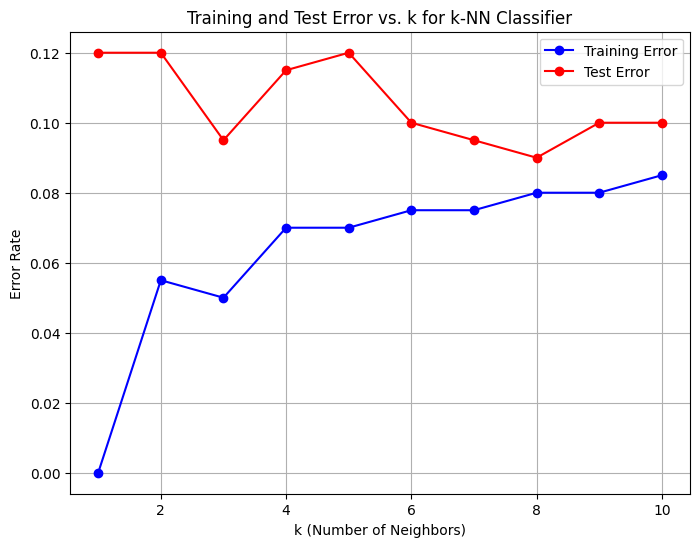

In [123]:
# Function to compute the error rate
def compute_error(y_true, y_pred):
    return np.mean(y_true != y_pred)

# Lists to store the errors for training and test data
train_errors = []
test_errors = []

# Loop over k values from 1 to 10
for k in range(1, 11):
    # Initialize and train the k-NN classifier
    knn = KNN(k)
    knn.fit(X_train, y_train)
    
    # Calculate training error
    y_train_pred = knn.predict(X_train)
    train_error = compute_error(y_train, y_train_pred)
    train_errors.append(train_error)
    
    # Calculate test error
    y_test_pred = knn.predict(X_test)
    test_error = compute_error(y_test, y_test_pred)
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_errors, label='Training Error', marker='o', linestyle='-', color='blue')
plt.plot(range(1, 11), test_errors, label='Test Error', marker='o', linestyle='-', color='red')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.title('Training and Test Error vs. k for k-NN Classifier')
plt.legend()
plt.grid(True)
plt.show()

### (b)

I would recommend a k value of 8 since the test error is lowest at that point.